# Deep Learning Assignment 2 Part 2: Transformers

### Transformers ([Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf))

To this point we have seen RNNs, which excel at sequence to sequence task but have two major drawbacks.
First, they can suffer from vanishing gradients for long sequences.
Second, they can take a long time to train due to sequential dependencies between hidden states which does not take advantage of the massively parallel architecture of modern GPUs.
The first issue is largely addressed by alternate RNN architectures (LSTMs, GRUs) but not the second.

Transformers solve these problems up to a certain extent by enabling to process the input parallely during training with long sequences. Though the computation is quadratic with respect to the input sequence length, it still managable with modern GPUs.

In this notebook, we will implement Transformers model step-by-step by referencing the original paper, [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf). We will also use a toy dataset to solve a vector-to-vector problem which is a subset of sequence-to-sequence problem.

## Table of Contents

This assignment has 4 parts. In the class we learned about Encoder based Transformers but often we use an Encoder and a Decoder for sequence to sequence task. In this notebook, you will learn how to implement an Encoder-Decoder based Transformers in a step-by-step manner. We will implement a simpler version here, where the simplicity arise from the task that we are solving, which is a vector-to-vector task. This essentially means that the length of input and output sequence is **fixed** and we dont have to worry about variable length of sequences. This makes the implementation simpler.

1. **Part I (Preparation)**: We will preprocess a toy dataset that consists of input arithmetic expression and an output result of the expression
1. **Part II (Implement Transformer blocks)**: we will look how to implement building blocks of a Transformer. It will consist of following blocks
   1. MultiHeadAttention
   2. FeedForward
   3. LayerNorm
   4. Encoder Block
   5. Decoder Block
1. **Part III (Data Loading)**: We will use the preprocessing functions in part I and the positional encoding module to construct the Dataloader.
1. **Part IV (Train a model)**: In the last part we will look at how to fit the implemented Transformer model to the toy dataset.

You can run all things on CPU till part 3. Part 4 requires GPU and while changing the runtime for this part, you would also have to run all the previous parts as part 4 has dependency on previous parts.

# Part I. Preparation

Before getting started we need to run some boilerplate code to set up our environment. You"ll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [335]:
# load_ext autoreload
# autoreload 2

### Google Colab Setup

Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [336]:
# Colab-only setup (Google Drive mount). Safe to ignore locally.
try:
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive")
except Exception:
    print("Not running on Colab: skipping Google Drive mount")

Not running on Colab: skipping Google Drive mount


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
["dl", "a2_helper.py", "rnn_lstm_captioning.ipynb",  "rnn_lstm_captioning.py", "transformers.py", "Transformers.ipynb", "two_digit_op.json"]
```

In [337]:
import sys
from pathlib import Path

# Local (non-Colab) setup: assume this notebook is inside the assignment folder.
ASSIGNMENT_DIR = Path.cwd().resolve()

# If launched from elsewhere, try to find the folder that contains transformers.py
if not (ASSIGNMENT_DIR / "transformers.py").exists():
    for candidate in [
        ASSIGNMENT_DIR / "assignment2",
        ASSIGNMENT_DIR.parent,
        ASSIGNMENT_DIR.parent / "assignment2",
    ]:
        if (candidate / "transformers.py").exists():
            ASSIGNMENT_DIR = candidate.resolve()
            break

print("Using ASSIGNMENT_DIR:", ASSIGNMENT_DIR)
sys.path.append(str(ASSIGNMENT_DIR))

Using ASSIGNMENT_DIR: /Users/samuelbenibgui/Desktop/Master/DL/DL-Attention


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from Transformers.py!
```

as well as the last edit time for the file `Transformers.py`.

In [338]:
import os
import time
from transformers import hello_transformers


os.environ["TZ"] = "Asia/Jerusalem"
time.tzset()
hello_transformers()

transformers_path = str(ASSIGNMENT_DIR / "transformers.py")
transformers_edit_time = time.ctime(os.path.getmtime(transformers_path))
print("transformers.py last edited on %s" % transformers_edit_time)

Hello from transformers.py!
transformers.py last edited on Thu Jan  8 13:44:50 2026


In [339]:
import torch
import torch.nn.functional as F
from torch import Tensor
from torch import nn

import torch

from torch import nn
import torch.nn.functional as F

from dl.utils import (
    reset_seed,
    tensor_to_image,
    attention_visualizer,
)
from dl.grad import rel_error, compute_numeric_gradient
import matplotlib.pyplot as plt
import time
from IPython.display import Image


# for plotting
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

We will use the GPU to accelerate our computation. Run this cell to make sure you are using a GPU.

We will be using `torch.float = torch.float32` for data and `torch.long = torch.int64` for labels.

Please refer to https://pytorch.org/docs/stable/tensor_attributes.html#torch-dtype for more details about data types.

In [340]:

# Device selection logic (unchanged)
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA GPU")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")

to_float = {"dtype": torch.float32, "device": DEVICE}

DOUBLE_DEVICE = DEVICE
if DEVICE.type == "mps":
    DOUBLE_DEVICE = torch.device("cpu")

to_double = {"dtype": torch.float64, "device": DOUBLE_DEVICE}

Using Apple Silicon GPU (MPS)


### Load the toy data

As Transformers perform very well on sequence to sequence task, we will implement it on a toy task of Arithmetic operations. We will use transformer models to perform addition and subraction of two integers, where the absolute value of an integer is at most 50. A simple example is to perform the computation `-5 + 2` using a Transformer model and getting the corect result as `-3`. As there can be multiple ways to solve this problem, we will see how we can pose this as a sequence to sequence problem and solve it using Transformers model. Note that we had to reduce the complexity of the problem to make the Transformer work within the constrainted resources of Colab.

Lets take a look at the data first:

In [341]:
from a2_helper import get_toy_data

# load the data using helper function
data = get_toy_data(str(ASSIGNMENT_DIR / "two_digit_op.json"))

### Looking at the first four examples

Below are the first four samples in the data

In [342]:
num_examples = 4
for q, a in zip(
    data["inp_expression"][:num_examples], 
    data["out_expression"][:num_examples]
    ):
  print("Expression: " + q + " Output: " + a)

Expression: BOS NEGATIVE 30 subtract NEGATIVE 34 EOS Output: BOS POSITIVE 04 EOS
Expression: BOS NEGATIVE 34 add NEGATIVE 15 EOS Output: BOS NEGATIVE 49 EOS
Expression: BOS NEGATIVE 28 add NEGATIVE 36 EOS Output: BOS NEGATIVE 64 EOS
Expression: BOS POSITIVE 00 subtract POSITIVE 17 EOS Output: BOS NEGATIVE 17 EOS


## What do these examples mean:

Lets look at first and third examples here and understand what they represent:

- Expression: `BOS NEGATIVE 30 subtract NEGATIVE 34 EOS` Output: `BOS POSITIVE 04 EOS`: The expression here is $(-30) - (-34)$. There are two notions of the symbol `+` here: one is to denote the sign of the number and other is the operation of addition between two integers. To simplify the problem for the neural network, we have denoted them with different text tokens. The ouput of $(-30) - (-34)$ is $+4$. Here `BOS` and `EOS` refer to begining of sequence and end of sequence
- Similarly, the second expression, `BOS NEGATIVE 34 add NEGATIVE 15 EOS` Output: `BOS NEGATIVE 49 EOS` means that we are doing the computation as $(-34) + (-15)$. As above, the symbol `-` here represents two things: first is the sign of an integer and second is the operation between two integers. Again, we have represented with different tokens to simplify the problem for the neural network. The output here is -49. Here `BOS` and `EOS` refer to begining of sequence and end of sequence

Now that we have a grasp on what is the data, lets head to preprocess the data, as the neural networks don't really understand strings, we need to represent them as numbers.

## Pre-processing the data
We need to convert the raw input sequence into a format that can be processed with a neural network.
Concretely, we need to convert a human-readable string (e.g. `BOS NEGATIVE 30 subtract NEGATIVE 34 EOS`) into a sequence of **tokens**, each of which will be an integer.
The process of converting an input string into a sequence of tokens is known as **tokenization**.

Before we can tokenize any particular sequence, we first need to build a **vocabulary**;
this is an exhaustive list of all tokens that appear in our dataset, and a mapping from each token to a unique integer value.
In our case, our vocabulary with consist of 16 elements: one entry for each digit `0` to `9`, two tokens to represent the sign of a number (`POSITIVE` and `NEGATIVE`), two tokens representing the addition and subtraction operations (`add`, and `subtract`), and finally two special tokens representing the start and end of the sequence (`BOS`, `EOS`).

We typically represent the vocabulary with a pair of data structures.
First is a list of all the string tokens (`vocab` below), such that `vocab[i] = s` means that the string `s` has been assigned the integer value `i`. This allows us to look up the string associated with any numeric index `i`.
We also need a data structure that enables us to map in the other direction: given a string `s`, find the index `i` to which it has been assigned. This is typically represented as a hash map (`dict` object in Python) whose keys are strings and whose values are the indices assigned to those strings.
You will implement the function `generate_token_dict` that inputs the list `vocab` and returns a dict `convert_str_to_token` giving this mapping.

Once you have built the vocab, then you can implement the function `preprocess_input_sequence` which uses the vocab data structures to convert an input string into a list of integer tokens.

In [343]:
# Create vocab
SPECIAL_TOKENS = ["POSITIVE", "NEGATIVE", "add", "subtract", "BOS", "EOS"]
vocab = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"] + SPECIAL_TOKENS

To generate the hash map and then process the input string using them, complete the `generate_token_dict`, `prepocess_input_sequence` functions in the python files for this exercise:

You should see exact zero errors here

In [344]:
from transformers import generate_token_dict

convert_str_to_tokens = generate_token_dict(vocab)

try:
    assert convert_str_to_tokens["0"] == 0
except:
    print("The first element does not map to 0. Please check the implementation")

try:
    assert convert_str_to_tokens["EOS"] == 15
except:
    print("The last element does not map to 2004. Please check the implementation")

print("Dictionary created successfully!")

Dictionary created successfully!


In [345]:
from transformers import prepocess_input_sequence

convert_str_to_tokens = generate_token_dict(vocab)

ex1_in = "BOS POSITIVE 0333 add POSITIVE 0696 EOS"
ex2_in = "BOS POSITIVE 0673 add POSITIVE 0675 EOS"
ex3_in = "BOS NEGATIVE 0286 subtract NEGATIVE 0044 EOS"
ex4_in = "BOS NEGATIVE 0420 add POSITIVE 0342 EOS"

ex1_out = "BOS POSITIVE 1029 EOS"
ex2_out = "BOS POSITIVE 1348 EOS"
ex3_out = "BOS NEGATIVE 0242 EOS"
ex4_out = "BOS NEGATIVE 0078 EOS"

ex1_inp_preprocessed = torch.tensor(
    prepocess_input_sequence(ex1_in, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex2_inp_preprocessed = torch.tensor(
    prepocess_input_sequence(ex2_in, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex3_inp_preprocessed = torch.tensor(
    prepocess_input_sequence(ex3_in, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex4_inp_preprocessed = torch.tensor(
    prepocess_input_sequence(ex4_in, convert_str_to_tokens, SPECIAL_TOKENS)
)

ex1_processed_expected = torch.tensor([14, 10, 0, 3, 3, 3, 12, 10, 0, 6, 9, 6, 15])
ex2_processed_expected = torch.tensor([14, 10, 0, 6, 7, 3, 12, 10, 0, 6, 7, 5, 15])
ex3_processed_expected = torch.tensor([14, 11, 0, 2, 8, 6, 13, 11, 0, 0, 4, 4, 15])
ex4_processed_expected = torch.tensor([14, 11, 0, 4, 2, 0, 12, 10, 0, 3, 4, 2, 15])

ex1_out = torch.tensor(
    prepocess_input_sequence(ex1_out, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex2_out = torch.tensor(
    prepocess_input_sequence(ex2_out, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex3_out = torch.tensor(
    prepocess_input_sequence(ex3_out, convert_str_to_tokens, SPECIAL_TOKENS)
)
ex4_out = torch.tensor(
    prepocess_input_sequence(ex4_out, convert_str_to_tokens, SPECIAL_TOKENS)
)

ex1_out_expected = torch.tensor([14, 10, 1, 0, 2, 9, 15])
ex2_out_expected = torch.tensor([14, 10, 1, 3, 4, 8, 15])
ex3_out_expected = torch.tensor([14, 11, 0, 2, 4, 2, 15])
ex4_out_expected = torch.tensor([14, 11, 0, 0, 7, 8, 15])

print(
    "preprocess input token error 1: ",
    rel_error(ex1_processed_expected, ex1_inp_preprocessed),
)
print(
    "preprocess input token error 2: ",
    rel_error(ex2_processed_expected, ex2_inp_preprocessed),
)
print(
    "preprocess input token error 3: ",
    rel_error(ex3_processed_expected, ex3_inp_preprocessed),
)
print(
    "preprocess input token error 4: ",
    rel_error(ex4_processed_expected, ex4_inp_preprocessed),
)
print("\n")
print("preprocess output token error 1: ", rel_error(ex1_out_expected, ex1_out))
print("preprocess output token error 2: ", rel_error(ex2_out_expected, ex2_out))
print("preprocess output token error 3: ", rel_error(ex3_out_expected, ex3_out))
print("preprocess output token error 4: ", rel_error(ex4_out_expected, ex4_out))

preprocess input token error 1:  0.0
preprocess input token error 2:  0.0
preprocess input token error 3:  0.0
preprocess input token error 4:  0.0


preprocess output token error 1:  0.0
preprocess output token error 2:  0.0
preprocess output token error 3:  0.0
preprocess output token error 4:  0.0


# Part II.  Implementing Transformer building blocks

Now that we have looked at the data, the task is to predict the output sequence (final result), something like `NEGATIVE 42` given the input sequence (of the arthmetic expression), something like `NEGATIVE 48 subtract NEGATIVE 6`.

In this section, we will look at implementing various building blocks used for implementing Transformer model. This will then be used to make Transformer encoder and decoder, which will ultimately lead us to implementing the complete Transfromer model.
Each block will be implemented as a subclass of `nn.Module`; we will use PyTorch autograd to compute gradients, so we don't need to implement backward passes manually.

We will implement the following blocks, by referencing the original paper:

1. MultHeadAttention Block
2. FeedForward Block
3. Layer Normalization
4. Positional Encoding block

We will then use these building blocks, combined with the input embedding layer to construct the Transformer Encoder and Decoder. We will start with MultiHeadAttention block, FeedForward Block, and Layer Normalization and look at Position encoding and input embedding later.

**Note:** One thing to keep in mind while implementing these blocks is that the shape of input and output Tensor from all these blocks we will be same. It always helps by checking the shapes of inputp and output tensors.

### MultiHeadAttention Block

The MultiHead Attention block is a key component of the Transformer model. It allows the model to attend to different positions of the input sequence simultaneously.

Transformers are sequence to sequence networks i.e., we get a sequence (for example a sentence in English) and get output a sequence (for example a sentence in Spanish). The input sequence are first transformed into embeddings as discussed in the RNN section and these embeddings are then passed through a Positional Encoding block. The resultant Embeddings are then transformed into three vectors, *query*, *key*, and *value* using learnable weights and we then use a Transformer Encoder and Decoder to get the final output sequence. For this section, we will assume that we have the *query*, *key*, and the *value* vector and work on them.

In the above figure, you can see that the Encoder has multihead attention block is right after these blocks. There is also a masked multihead attention in the deocoder but we will see that it's easy to implement the masked attention when we have implemented the basic MultiHeadAttention block.
To implement the basic MultiheadAttention block, we will first implement the Self Attention block and see that MultiHeadAttention can be implemented as a direct extension of the Self Attention block.

## Self Attention Block

Taking inspiration from information retreival paradigm, Transformers have this notion of *query*, *key*, and *value* where given a *query* we try extract information from *key*-*value* pairs. Moving along those lines, we perform this mathematically by taking the weighted sum of *values* for each *query*, where weight is computed by dot product of *query* and the *key*. More precisely, for each query we compute the dot product with all the keys and then use the scalar output of those dot products as weights to find the weighted sum of *values*. Note that before finding the weighted sum, we also apply softmax function to the weights vector. Lets start with implementing of Attention Block that takes input as *query*, *key*, and *value* vectors and returns a Tensor, that is weighted sum of the *values*.

For this section, you need to implement three functions, `scaled_dot_product_two_loop_single`, `scaled_dot_product_two_loop_batch`, and `scaled_dot_product_no_loop_batch` inside the transformers.py file. This might look very similar to the `dot_product_attention` in the RNN notebook but there is a subtle difference in the inputs. You should see the errors of the order less than 1e-5

In [346]:
from transformers import (
    scaled_dot_product_two_loop_single,
    scaled_dot_product_two_loop_batch,
    scaled_dot_product_no_loop_batch,
)

In [347]:
N = 2  # Number of sentences
K = 5  # Number of words in a sentence
M = 4  # feature dimension of each word embedding

query = torch.linspace(-0.4, 0.6, steps=K * M).reshape(K, M)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=K * M).reshape(K, M)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=K * M).reshape(K, M)  # *to_double_cuda

y = scaled_dot_product_two_loop_single(query, key, value)
y_expected = torch.tensor(
    [
        [0.08283, 0.14073, 0.19862, 0.25652],
        [0.13518, 0.19308, 0.25097, 0.30887],
        [0.18848, 0.24637, 0.30427, 0.36216],
        [0.24091, 0.29881, 0.35670, 0.41460],
        [0.29081, 0.34871, 0.40660, 0.46450],
    ]
).to(torch.float32)
print("sacled_dot_product_two_loop_single error: ", rel_error(y_expected, y))

sacled_dot_product_two_loop_single error:  5.204997336388729e-06


In [348]:
N = 2  # Number of sentences
K = 5  # Number of words in a sentence
M = 4  # feature dimension of each word embedding

query = torch.linspace(-0.4, 0.6, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=N * K * M).reshape(N, K, M)  # *to_double_cuda

y = scaled_dot_product_two_loop_batch(query, key, value)
y_expected = torch.tensor(
    [
        [
            [-0.09603, -0.06782, -0.03962, -0.01141],
            [-0.08991, -0.06170, -0.03350, -0.00529],
            [-0.08376, -0.05556, -0.02735, 0.00085],
            [-0.07760, -0.04939, -0.02119, 0.00702],
            [-0.07143, -0.04322, -0.01502, 0.01319],
        ],
        [
            [0.49884, 0.52705, 0.55525, 0.58346],
            [0.50499, 0.53319, 0.56140, 0.58960],
            [0.51111, 0.53931, 0.56752, 0.59572],
            [0.51718, 0.54539, 0.57359, 0.60180],
            [0.52321, 0.55141, 0.57962, 0.60782],
        ],
    ]
).to(torch.float32)
print("scaled_dot_product_two_loop_batch error: ", rel_error(y_expected, y))

scaled_dot_product_two_loop_batch error:  4.069603357824827e-06


In [349]:
N = 2  # Number of sentences
K = 5  # Number of words in a sentence
M = 4  # feature dimension of each word embedding

query = torch.linspace(-0.4, 0.6, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=N * K * M).reshape(N, K, M)  # *to_double_cuda


y, _ = scaled_dot_product_no_loop_batch(query, key, value)

y_expected = torch.tensor(
    [
        [
            [-0.09603, -0.06782, -0.03962, -0.01141],
            [-0.08991, -0.06170, -0.03350, -0.00529],
            [-0.08376, -0.05556, -0.02735, 0.00085],
            [-0.07760, -0.04939, -0.02119, 0.00702],
            [-0.07143, -0.04322, -0.01502, 0.01319],
        ],
        [
            [0.49884, 0.52705, 0.55525, 0.58346],
            [0.50499, 0.53319, 0.56140, 0.58960],
            [0.51111, 0.53931, 0.56752, 0.59572],
            [0.51718, 0.54539, 0.57359, 0.60180],
            [0.52321, 0.55141, 0.57962, 0.60782],
        ],
    ]
).to(torch.float32)

print("scaled_dot_product_no_loop_batch error: ", rel_error(y_expected, y))

scaled_dot_product_no_loop_batch error:  4.069603357824827e-06


## Observing time complexity:

As Transformers are infamous for their time complexity that depends on the size of the input sequence.
We can verify this now that we have implemented `self_attention_no_loop`.
Run the cells below: the first has a sequence length of 256 and the second one has a sequence length of 512. You should roughly be 4 times slower with sequence length 512, hence showing that compleixity of the transformers increase quadratically with resprect to increase in the in sequence length.
The `%timeit` lines may take several seconds to run.

In [350]:
N = 64
K = 256  # defines the input sequence length
M = emb_size = 2048
dim_q = dim_k = 2048
query = torch.linspace(-0.4, 0.6, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=N * K * M).reshape(N, K, M)  # *to_double_cuda

%timeit -n 5 -r 2  y = scaled_dot_product_no_loop_batch(query, key, value)

47.4 ms ± 3.87 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


In [351]:
N = 64
K = 512  # defines the input requence length
M = emb_size = 2048
dim_q = dim_k = 2048
query = torch.linspace(-0.4, 0.6, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=N * K * M).reshape(N, K, M)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=N * K * M).reshape(N, K, M)  # *to_double_cuda

%timeit -n 5 -r 2  y = scaled_dot_product_no_loop_batch(query, key, value)

151 ms ± 8.06 ms per loop (mean ± std. dev. of 2 runs, 5 loops each)


Now that we have implemented `scaled_dot_product_no_loop_batch`, lets implement `SingleHeadAttention`, that will serve as a building block for the `MultiHeadAttention` block. For this exercise, we have made a `SingleHeadAttention` class that inherits from `nn.module` class of Pytorch. You need to implement the `__init__` and the `forward` functions inside `Transformers.py`

Run the following cells to test your implementation of `SelfAttention` layer. We have also written code to check the backward pass using pytorch autograd API in the following cell. You should expect the error to be less than 1e-5

In [352]:
from transformers import SelfAttention

In [353]:
reset_seed(0)
N = 2
K = 4
M = emb_size = 4
dim_q = dim_k = 4
atten_single = SelfAttention(emb_size, dim_q, dim_k)

for k, v in atten_single.named_parameters():
    # print(k, v.shape) # uncomment this to see the weight shape
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

query = torch.linspace(-0.4, 0.6, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  # *to_double_cuda

query.retain_grad()
key.retain_grad()
value.retain_grad()

y_expected = torch.tensor(
    [
        [
            [-1.10382, -0.37219, 0.35944, 1.09108],
            [-1.45792, -0.50067, 0.45658, 1.41384],
            [-1.74349, -0.60428, 0.53493, 1.67414],
            [-1.92584, -0.67044, 0.58495, 1.84035],
        ],
        [
            [-4.59671, -1.63952, 1.31767, 4.27486],
            [-4.65586, -1.66098, 1.33390, 4.32877],
            [-4.69005, -1.67339, 1.34328, 4.35994],
            [-4.71039, -1.68077, 1.34886, 4.37848],
        ],
    ]
)

dy_expected = torch.tensor(
    [
        [
            [-0.09084, -0.08961, -0.08838, -0.08715],
            [0.69305, 0.68366, 0.67426, 0.66487],
            [-0.88989, -0.87783, -0.86576, -0.85370],
            [0.25859, 0.25509, 0.25158, 0.24808],
        ],
        [
            [-0.05360, -0.05287, -0.05214, -0.05142],
            [0.11627, 0.11470, 0.11312, 0.11154],
            [-0.01048, -0.01034, -0.01019, -0.01005],
            [-0.03908, -0.03855, -0.03802, -0.03749],
        ],
    ]
)

y = atten_single(query, key, value)
dy = torch.randn(*y.shape)  # , **to_double_cuda

y.backward(dy)
query_grad = query.grad

print("SelfAttention error: ", rel_error(y_expected, y))
print("SelfAttention error: ", rel_error(dy_expected, query_grad))

SelfAttention error:  5.567699890042989e-07
SelfAttention error:  3.2296862072882684e-06


We have implemented the `SingleHeadAttention` block which brings use very close to implementing `MultiHeadAttention`. We will now see that this can be achieved by manipulating the shapes of input tensors based on number of heads in the Multi-Attention block. We design a network that uses multiple SingleHeadAttention blocks on the same input to compute the output tensors and finally concatenate them to generate a single output. This is not the implementation used in practice as it forces you to initialize multiple layers but we use it here for simplicity. Implement MultiHeadAttention block in the `transformers.py` file by using the SingleHeadAttention block.

Run the following cells to test your `MultiHeadAttention` layer. Again, as `SelfAttention`, we have used pytorch autograd API to test the backward pass. You should expect error values below 1e-5.

In [354]:
from transformers import MultiHeadAttention

In [355]:
reset_seed(0)
N = 2
num_heads = 2
K = 4
M = inp_emb_size = 4
out_emb_size = 8
atten_multihead = MultiHeadAttention(num_heads, inp_emb_size, out_emb_size)

for k, v in atten_multihead.named_parameters():
    # print(k, v.shape) # uncomment this to see the weight shape
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

query = torch.linspace(-0.4, 0.6, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  # **to_double_cuda
key = torch.linspace(-0.8, 0.5, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  # **to_double_cuda
value = torch.linspace(-0.3, 0.8, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  # *to_double_cuda

query.retain_grad()
key.retain_grad()
value.retain_grad()

y_expected = torch.tensor(
    [
        [
            [-0.23104, 0.50132, 1.23367, 1.96603],
            [0.68324, 1.17869, 1.67413, 2.16958],
            [1.40236, 1.71147, 2.02058, 2.32969],
            [1.77330, 1.98629, 2.19928, 2.41227],
        ],
        [
            [6.74946, 5.67302, 4.59659, 3.52015],
            [6.82813, 5.73131, 4.63449, 3.53767],
            [6.86686, 5.76001, 4.65315, 3.54630],
            [6.88665, 5.77466, 4.66268, 3.55070],
        ],
    ]
)
dy_expected = torch.tensor(
    [[[ 0.56268,  0.55889,  0.55510,  0.55131],
         [ 0.43286,  0.42994,  0.42702,  0.42411],
         [ 2.29865,  2.28316,  2.26767,  2.25218],
         [ 0.49172,  0.48841,  0.48509,  0.48178]],

        [[ 0.25083,  0.24914,  0.24745,  0.24576],
         [ 0.14949,  0.14849,  0.14748,  0.14647],
         [-0.03105, -0.03084, -0.03063, -0.03043],
         [-0.02082, -0.02068, -0.02054, -0.02040]]]
)

y = atten_multihead(query, key, value)
dy = torch.randn(*y.shape)  # , **to_double_cuda

y.backward(dy)
query_grad = query.grad
print("MultiHeadAttention error: ", rel_error(y_expected, y))
print("MultiHeadAttention error: ", rel_error(dy_expected, query_grad))

MultiHeadAttention error:  3.808245557889279e-07
MultiHeadAttention error:  2.0193197100539535e-06


### LayerNormalization

Layer Normalization is used throughout the Transformer model. It normalizes the inputs across the features for each sample independently, helping to stabilize training.

We implemented BatchNorm while working with CNNs. One of the problems of BatchNorm is its dependency on the the complete batch which might not give good results when the batch size is small. Ba et al proposed `LayerNormalization` that takes into account these problems and has become a standard in sequence-to-sequence tasks. In this section, we will implement `LayerNormalization`. Another nice quality of `LayerNormalization` is that as it depends on individual time steps or each element of the sequence, it can be parallelized and the test time runs in a similar manner hence making it better implementation wise. Again, you have to only implement the forward pass and the backward pass will be taken care by Pytorch autograd. Implement the `LayerNormalization` class in `transformers.py`, you should expect the error below 1e-5

In [356]:
from transformers import LayerNormalization

In [357]:
reset_seed(0)
N = 2
K = 4
norm = LayerNormalization(K)
inp = torch.linspace(-0.4, 0.6, steps=N * K, requires_grad=True).reshape(N, K)

inp.retain_grad()
y = norm(inp)

y_expected = torch.tensor(
    [[-1.34164, -0.44721, 0.44721, 1.34164], [-1.34164, -0.44721, 0.44721, 1.34164]]
)

dy_expected = torch.tensor(
    [[  5.70524,  -2.77289, -11.56993,   8.63758],
        [  2.26242,  -4.44330,   2.09933,   0.08154]]
)

dy = torch.randn(*y.shape)
y.backward(dy)
inp_grad = inp.grad

print("LayerNormalization error: ", rel_error(y_expected, y))
print("LayerNormalization grad error: ", rel_error(dy_expected, inp_grad))

LayerNormalization error:  1.3772273765080196e-06
LayerNormalization grad error:  2.2087854796632033e-07


### FeedForward Block

The FeedForward Block is used in both the Encoder and Decoder of the Transformer. It consists of two linear transformations with a ReLU activation in between.

Next, we will implement the `Feedforward` block. These are used in both the Encoder and Decoder network of the Transformer and they consist of stacked MLP and ReLU layers. In the overall architecture, the output of `MultiHeadAttention` is fed into the `FeedForward` block. Implement the `FeedForwardBlock` inside `transformers.py` and execute the following cells to check your implementation. You should expect the errors below 1e-5

In [358]:
from transformers import FeedForwardBlock

In [359]:
reset_seed(0)
N = 2
K = 4
M = emb_size = 4

ff_block = FeedForwardBlock(emb_size, 2 * emb_size)

for k, v in ff_block.named_parameters():
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

inp = torch.linspace(-0.4, 0.6, steps=N * K, requires_grad=True).reshape(
    N, K
) 
inp.retain_grad()
y = ff_block(inp)

y_expected = torch.tensor(
    [[-2.46161, -0.71662, 1.02838, 2.77337], [-7.56084, -1.69557, 4.16970, 10.03497]]
)

dy_expected = torch.tensor(
    [[0.55105, 0.68884, 0.82662, 0.96441], [0.30734, 0.31821, 0.32908, 0.33996]]
)

dy = torch.randn(*y.shape)
y.backward(dy)
inp_grad = inp.grad

print("FeedForwardBlock error: ", rel_error(y_expected, y))
print("FeedForwardBlock error: ", rel_error(dy_expected, inp_grad))

FeedForwardBlock error:  2.1976864847460601e-07
FeedForwardBlock error:  2.317660816458136e-06


Now, if you look back to the original paper, Attention is all you Need, then, we are almost done with the building blocks of a transformer. What's left is:

- Encapsulating the building blocks into Encoder Block
- Encapsulating the building blocks into Decoder Block
- Handling the input data preprocessing and positional encoding.

We will first look at implementing the Encoder Block and Decoder block. The positional encoding is a non learnable embedding and we can treat it as a preprocessing step in our DataLoader.

The Encoder Block combines MultiHead Attention, Layer Normalization, and FeedForward layers with residual connections. Each encoder block processes the input sequence and passes it to the next layer.

As shown in the figure above, the encoder block takes it inputs three tensors. We will assume that we have those three tensors, query, key, and value. Run the cell below to check your implementation of the EncoderBlock. You should expect the errors below 1e-5

In [360]:
from transformers import EncoderBlock

In [361]:
reset_seed(0)
N = 2
num_heads = 2
emb_dim = K = 4
feedforward_dim = 8
M = inp_emb_size = 4
out_emb_size = 8
dropout = 0.2

enc_seq_inp = torch.linspace(-0.4, 0.6, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  # **to_double_cuda

enc_block = EncoderBlock(num_heads, emb_dim, feedforward_dim, dropout)

for k, v in enc_block.named_parameters():
    # print(k, v.shape) # uncomment this to see the weight shape
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

encoder_out1_expected = torch.tensor(
    [[[ 0.00000, -0.31357,  0.69126,  0.00000],
         [ 0.42630, -0.25859,  0.72412,  3.87013],
         [ 0.00000, -0.31357,  0.69126,  3.89884],
         [ 0.47986, -0.30568,  0.69082,  3.90563]],

        [[ 0.00000, -0.31641,  0.69000,  3.89921],
         [ 0.47986, -0.30568,  0.69082,  3.90563],
         [ 0.47986, -0.30568,  0.69082,  3.90563],
         [ 0.51781, -0.30853,  0.71598,  3.85171]]]
)
encoder_out1 = enc_block(enc_seq_inp)
print("EncoderBlock error 1: ", rel_error(encoder_out1, encoder_out1_expected))


N = 2
num_heads = 1
emb_dim = K = 4
feedforward_dim = 8
M = inp_emb_size = 4
out_emb_size = 8
dropout = 0.2

enc_seq_inp = torch.linspace(-0.4, 0.6, steps=N * K * M, requires_grad=True).reshape(
    N, K, M
)  # **to_double_cuda

enc_block = EncoderBlock(num_heads, emb_dim, feedforward_dim, dropout)

for k, v in enc_block.named_parameters():
    # print(k, v.shape) # uncomment this to see the weight shape
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

encoder_out2_expected = torch.tensor(
    [[[ 0.42630, -0.00000,  0.72412,  3.87013],
         [ 0.49614, -0.31357,  0.00000,  3.89884],
         [ 0.47986, -0.30568,  0.69082,  0.00000],
         [ 0.51654, -0.32455,  0.69035,  3.89216]],

        [[ 0.47986, -0.30568,  0.69082,  0.00000],
         [ 0.49614, -0.31357,  0.69126,  3.89884],
         [ 0.00000, -0.30354,  0.76272,  3.75311],
         [ 0.49614, -0.31357,  0.69126,  3.89884]]]
)
encoder_out2 = enc_block(enc_seq_inp)
print("EncoderBlock error 2: ", rel_error(encoder_out2, encoder_out2_expected))

EncoderBlock error 1:  0.5004355367965815
EncoderBlock error 2:  0.5004352310674638


Great! You're almost done with the implementation of the Transformer model.

### Decoder Block

The Decoder Block is similar to the Encoder but includes an additional masked self-attention layer and a cross-attention layer that attends to the encoder output.

Now, we will look at the implementation of the decoder. In the  class we learned about encoder only model that can be used for tasks like sequence classification but for more complicated tasks like sequence to sequence we need a decoder network that can transform the output of the encoder to a target sequence. This kind of architecture is important in tasks like language translation where we have a sequence as input and a sequence as output. This decoder takes the input from the encoder and the previous generated value to generate the next value. During training, we use a Mask on the input so that the decoder network can't look ahead in the future and during inference we sequentially process the data.

Before moving to implementing the Decoder Block, we should pay attention to the figure above. It says a "Masked MultiHead Attention" which actually prevents the decoder from looking ahead into the future. Lets understand with an example here. We have an expression as `BOS POSITIVE 01 add POSITIVE 00 EOS`, i.e. `1+0` that gives output as `BOS POSITIVE 01 EOS`, i.e. `+1`. Lets focus on the output sequence here. This is a sequence of length 5 (after applying our preprocessing code) and will will get transformed into *key*, *query*, and *value* matrix of dimension $5\times128$, $5\times128$ and $5\times128$ respectively, where 128 is the embedding dimension of the Transformer. Now, while training, we input these vectors in the `self_attention_no_loop_batch` without mask. It will compute the dot product between *query* and *key* to generate a $5\times5$ matrix where the first row (shape $1\times5$) of that matrix tells us how much the word `EOS` is related with `EOS`, `POSITIVE`, `0`, `1`, and `EOS`. This means that it will use the weights of all these tokens to learn the final sequence that is to be predicted. This is okay when we are training the model but what happens when we perform inference? We start with a brand new expression, input this expression in the encoder but this time we only have the first starting token `EOS` for decoder and we don't know about the rest of the tokens in the sequence. Hence, a solution to this problem is to mask the weights inside the function `self_attention_no_loop_batch` for only the decoder part. This masking should prevent the decoder from accessing the future or next elements.

We will now look at how to generate this mask for a given sequence. Then, you should also update the `self_attention_no_loop_batch` to use the mask variable appropriately. Implement the `get_subsequent_mask`, `self_attention_no_loop_batch` with mask inside `transformers.py` file

In [362]:
from transformers import get_subsequent_mask

reset_seed(0)
seq_len_enc = K = 4
M = inp_emb_size = 3

inp_sequence = torch.linspace(-0.4, 0.6, steps=K * M, requires_grad=True).reshape(
    K, M
)  # **to_double_cuda

mask_expected = torch.tensor(
    [
        [[False, True, True], [False, False, True], [False, False, False]],
        [[False, True, True], [False, False, True], [False, False, False]],
        [[False, True, True], [False, False, True], [False, False, False]],
        [[False, True, True], [False, False, True], [False, False, False]],
    ]
)
mask_predicted = get_subsequent_mask(inp_sequence)
print(
    "get_subsequent_mask error: ", rel_error(mask_predicted.int(), mask_expected.int())
)

get_subsequent_mask error:  0.0


In [363]:
from transformers import scaled_dot_product_no_loop_batch

In [364]:
reset_seed(0)
N = 4
K = 3
M = 3

query = torch.linspace(-0.4, 0.6, steps=K * M * N, requires_grad=True).reshape(N, K, M)
key = torch.linspace(-0.1, 0.2, steps=K * M * N, requires_grad=True).reshape(N, K, M)
value = torch.linspace(0.4, 0.8, steps=K * M * N, requires_grad=True).reshape(N, K, M)

y_expected = torch.tensor(
    [
        [
            [0.40000, 0.41143, 0.42286],
            [0.41703, 0.42846, 0.43989],
            [0.43408, 0.44551, 0.45694],
        ],
        [
            [0.50286, 0.51429, 0.52571],
            [0.51999, 0.53142, 0.54285],
            [0.53720, 0.54863, 0.56006],
        ],
        [
            [0.60571, 0.61714, 0.62857],
            [0.62294, 0.63437, 0.64580],
            [0.64032, 0.65175, 0.66318],
        ],
        [
            [0.70857, 0.72000, 0.73143],
            [0.72590, 0.73733, 0.74876],
            [0.74344, 0.75487, 0.76630],
        ],
    ]
)
y_predicted, _ = scaled_dot_product_no_loop_batch(query, key, value, mask_expected)

print("scaled_dot_product_no_loop_batch error: ", rel_error(y_expected, y_predicted))

scaled_dot_product_no_loop_batch error:  2.8390646269892996e-06


Lets finally implement the decoder block now that we have all the required tools to implement it. Fill in the init function and the forward pass of the `DecoderBlock` inside `transformers.py`. Run the following cells to check your implementation of the `DecoderBlock`. You should expect the errors below 1e-5.

In [365]:
from transformers import DecoderBlock

In [366]:
reset_seed(0)
N = 2
num_heads = 2
seq_len_enc = K1 = 4
seq_len_dec = K2 = 2
feedforward_dim = 8
M = emb_dim = 4
out_emb_size = 8
dropout = 0.2

dec_inp = torch.linspace(-0.4, 0.6, steps=N * K1 * M, requires_grad=True).reshape(
    N, K1, M
)
enc_out = torch.linspace(-0.4, 0.6, steps=N * K2 * M, requires_grad=True).reshape(
    N, K2, M
)
dec_block = DecoderBlock(num_heads, emb_dim, feedforward_dim, dropout)

for k, v in dec_block.named_parameters():
    # print(k, v.shape) # uncomment this to see the weight shape
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))


dec_out_expected = torch.tensor(
    [[[ 0.50623, -0.32496,  0.00000,  0.00000],
         [ 0.00000, -0.31690,  0.76956,  3.72647],
         [ 0.49014, -0.32809,  0.66595,  3.93773],
         [ 0.00000, -0.00000,  0.68203,  3.90856]],

        [[ 0.51042, -0.32787,  0.68093,  3.90848],
         [ 0.00000, -0.31637,  0.72275,  3.83122],
         [ 0.64868, -0.00000,  0.77715,  0.00000],
         [ 0.00000, -0.33105,  0.66565,  3.93602]]]
)
dec_out1 = dec_block(dec_inp, enc_out)
print("DecoderBlock error: ", rel_error(dec_out1, dec_out_expected))

N = 2
num_heads = 2
seq_len_enc = K1 = 4
seq_len_dec = K2 = 4
feedforward_dim = 4
M = emb_dim = 4
out_emb_size = 8
dropout = 0.2

dec_inp = torch.linspace(-0.4, 0.6, steps=N * K1 * M, requires_grad=True).reshape(
    N, K1, M
)
enc_out = torch.linspace(-0.4, 0.6, steps=N * K2 * M, requires_grad=True).reshape(
    N, K2, M
)
dec_block = DecoderBlock(num_heads, emb_dim, feedforward_dim, dropout)

for k, v in dec_block.named_parameters():
    # print(k, v.shape) # uncomment this to see the weight shape
    v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))


dec_out_expected = torch.tensor(
    [[[ 0.46707, -0.31916,  0.66218,  3.95182],
         [ 0.00000, -0.31116,  0.66325,  0.00000],
         [ 0.44538, -0.32419,  0.64068,  3.98847],
         [ 0.49012, -0.31276,  0.68795,  3.90610]],

        [[ 0.45800, -0.33023,  0.64106,  3.98324],
         [ 0.45829, -0.31487,  0.66203,  3.95529],
         [ 0.59787, -0.00000,  0.72361,  0.00000],
         [ 0.70958, -0.37051,  0.78886,  3.63179]]]
)
dec_out2 = dec_block(dec_inp, enc_out)
print("DecoderBlock error: ", rel_error(dec_out2, dec_out_expected))

DecoderBlock error:  0.5214426297809118
DecoderBlock error:  0.5045064280866626


Based on the implementation of `EncoderBlock` and `DecoderBlock`, we have implemented the `Encoder` and `Decoder` networks for you in transformers.py. You should be able to understand the input and outputs of these Encoder and Decoder blocks. Implement the Transformer block inside transformer.py using these networks.

## Part III: Data loader

In this part, we will have a look at creating the final data loader for the task, that can be used to train the Transformer model. This will comprise of two things:

- Implement Positional Encoding
- Create a dataloader using the `prepocess_input_sequence` fucntion that we created in Part I.

Lets start with implementing the Positional Encoding for the input. The positional encodings make the Transformers positionally aware about sequences. These are usually added to the input and hence should be same shape as input. As these are not learnable, they remain constant throughtout the training process. For this reason, we can look at it as a pre-processing step that's done on the input. Our strategy here would be to implement positional encoding function and use it later while creating DataLoader for the toy dataset.

Lets look at the simplest kind of positional encoding, i.e. for a sequence of length K, assign the nth element in the sequence a value of n/K, where n starts from 0. Implement the position_encoding_simple inside `transformers.py`. You should expect error less than 1e-9 here.

### Simple positional encoding

In [367]:
from transformers import position_encoding_simple

reset_seed(0)
K = 4
M = emb_size = 4

y = position_encoding_simple(K, M)
y_expected = torch.tensor(
    [
        [
            [0.00000, 0.00000, 0.00000, 0.00000],
            [0.25000, 0.25000, 0.25000, 0.25000],
            [0.50000, 0.50000, 0.50000, 0.50000],
            [0.75000, 0.75000, 0.75000, 0.75000],
        ]
    ]
)

print("position_encoding_simple error: ", rel_error(y, y_expected))

K = 5
M = emb_size = 3


y = position_encoding_simple(K, M)
y_expected = torch.tensor(
    [
        [
            [0.00000, 0.00000, 0.00000],
            [0.20000, 0.20000, 0.20000],
            [0.40000, 0.40000, 0.40000],
            [0.60000, 0.60000, 0.60000],
            [0.80000, 0.80000, 0.80000],
        ]
    ]
)
print("position_encoding_simple error: ", rel_error(y, y_expected))

position_encoding_simple error:  0.0
position_encoding_simple error:  0.0


### Sinusoid positional encoding

Now that we have looked at a simple positional encoding, we can see one major drawback, which is that if the sequence length gets larger, the difference between two consecutive positional encodings becomes smaller and smaller and it in turn defeats a purpose of positional awareness, as there is very small diference in two consecutive positions. Another issue is that for each position we replicated it along embedding dimension, hence introducing redundancy which might not help the network in learning anything new. There could be different tricks that can be used to make a positional encoding that could solve these problems.

Lets look at more mature version of a positonal encoding that uses a combination of sines and cosines function, also called sinusoid. This is also the positional encoding used in the original Transformer paper. For each element in the sequence (length K) with position $p$ and embedding (dimension M) positon $i$, we can define the positional encoding as:

$$PE_{(p, 2i)} = \sin\left(\frac{p}{10000^a}\right)$$
$$PE_{(p, 2i+1)} = \cos\left(\frac{p}{10000^a}\right)$$

$$\text{Where }a = \left\lfloor{\frac{2i}{M}}\right\rfloor \text{and M is the Embedding dimension of the Transformer}$$

Here, $p$ remains constant for a position in the sequence and we assign alternating sines and cosines along the embedding dimension.

Implement the fucntion `position_encoding` inside `transformers.py`. You should expect errors below 1e-5.

In [368]:
from transformers import position_encoding_sinusoid

reset_seed(0)
K = 4
M = emb_size = 4

y1 = position_encoding_sinusoid(K, M)
y_expected = torch.tensor(
    [
        [
            [0.00000, 1.00000, 0.00000, 1.00000],
            [0.84147, 0.54030, 0.84147, 0.54030],
            [0.90930, -0.41615, 0.90930, -0.41615],
            [0.14112, -0.98999, 0.14112, -0.98999],
        ]
    ]
)

print("position_encoding error: ", rel_error(y1, y_expected))

K = 5
M = emb_size = 3


y2 = position_encoding_sinusoid(K, M)
y_expected = torch.tensor(
    [
        [
            [0.00000, 1.00000, 0.00000],
            [0.84147, 0.54030, 0.84147],
            [0.90930, -0.41615, 0.90930],
            [0.14112, -0.98999, 0.14112],
            [-0.75680, -0.65364, -0.75680],
        ]
    ]
)
print("position_encoding error: ", rel_error(y2, y_expected))

position_encoding error:  1.5795230865478516e-06
position_encoding error:  1.817941665649414e-06


### Constructing the DataLoader for the toy dataset

Now we will use the implemented positonal encodings to construct a DataLoader in Pytorch. The function of a data loader is to return a batch for training/validation. We first make a Dataset class that gives us a single element in the batch and then use a DataLoader to wrap the dataset. We inherit the Dataset from `torch.utils.data.Dataset` class. This class consists of two important functions that you'd change depending on your usecase (for e.g. the upcoming project!). The first function is `__init__`, this consists of the components that are *static*, in other words, these are the variables that won't change when we want the next element from the complete data. The second fucntion is `__getitem__` which contains the core functionality of the final dataloader.

To get the final dataloader, we wrap the `train_data` and `test_data` in `torch.utils.data.DataLoader` class

In [369]:
from sklearn.model_selection import train_test_split
from transformers import AddSubDataset

BATCH_SIZE = 16

X, y = data["inp_expression"], data["out_expression"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

train_data = AddSubDataset(
    X_train,
    y_train,
    convert_str_to_tokens,
    SPECIAL_TOKENS,
    32,
    position_encoding_simple,
)
valid_data = AddSubDataset(
    X_test, y_test, convert_str_to_tokens, SPECIAL_TOKENS, 32, position_encoding_simple
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)

## Part IV: Using transformer on the toy dataset

In this part, we will put all the parts together to train a transformer model. We have implemented most of the functions here for you and your task would be to use these functions to train a Transformer model. The overall tasks are divided into three parts:

- Implement the Transformer model using previusly implemented functions
- Overfitting the model
- Training using complete data
- Visualizing the attention

In [370]:
from tqdm import tqdm

### Implement the Transformer model

The complete Transformer model combines the Encoder and Decoder stacks with input/output embeddings and a final linear layer that maps to the vocabulary size.

Implement the Transformer model in `transformer.py` and run the cells below to check the final shapes of the output

In [371]:
import torch.optim as optim
from transformers import Transformer

inp_seq_len = 9
out_seq_len = 5
num_heads = 4
emb_dim = 32
dim_feedforward = 64
dropout = 0.2
num_enc_layers = 4
num_dec_layers = 4
vocab_len = len(vocab)

model = Transformer(
    num_heads,
    emb_dim,
    dim_feedforward,
    dropout,
    num_enc_layers,
    num_dec_layers,
    vocab_len,
)
for it in train_loader:
  it
  break
inp, inp_pos, out, out_pos = it
device = DEVICE
model = model.to(device)
inp_pos = inp_pos.to(device)
out_pos = out_pos.to(device)
out = out.to(device)
inp = inp.to(device)


model_out = model(inp.long(), inp_pos, out.long(), out_pos)
assert model_out.size(0) == BATCH_SIZE * (out_seq_len - 1)
assert model_out.size(1) == vocab_len

### Overfitting the model using small data

Now that we have implemented the Transformer model, lets overfit on a small dataset. This will ensure that the implementation is correct. We keep the training and validation data same here. Before doing that, a couple of things to keep in mind:

- We implemented two versions of positional encodings: simple and sinusoid. For overfitting, we will use the simple positional encoding but feel free to experiment with both when training for the complete model
- In transformers.py, we have implemented two loss functions for you. The first is the familiar cross entropy loss and second is the `LabelSmoothingLoss`. For overfitting, we will use the cross entropy loss but feel free to experiment with both while doing experiment with the complete data.
- Usually, the training regime of Transformers start with a warmup, in other words, we train the model with a lower learning rate for some iterations and then increasing the learning rate to make the network learn faster. Intuitively, this helps you to attain a stable manifold in the loss function and then we increase the learning rate to learn faster in this stable manifold. In a way we are warming up the network to be in a stable manifold and we start training with a higher learning rate after this warm-up. For overfitting we have NOT used this warm-up as for such small data, it is okay to start with a higer learning rate but you should keep this in mind while training with the complete data. We have used two functions from a5_helper.py, `train` and `val`. Here, `train` has three parameters that you should pay attention to:
  - `warmup_interval`: Specifies the number of iterations that the network should train with a low learning rate. In other words, its the number of iterations after which the network will have the higher learning rate
  - `warmup_lr`: This is the learning rate that will be used during warmup.
  - `lr`: This is the learning rate that will get used after the warm-up. If warmup_interval is None, we will start training with this learning rate.

In the following cells for overfitting, we have used the number of epochs as 200 but you could increase this. You should get an accuracy ~1 in 200 epochs. It might be a little lower as well, don't worry about it. It should take about a minute to run the overfitting.

NOTE: When we say epoch, it means the number of times we have taken a complete pass over the data. One epoch typically consists of many iterations that depend on the batch size.

In [372]:
from transformers import LabelSmoothingLoss, CrossEntropyLoss
import torch.optim as optim
from transformers import Transformer
from a2_helper import train as train_transformer
from a2_helper import val as val_transformer

In [373]:
inp_seq_len = 9
out_seq_len = 5
num_heads = 4
emb_dim = 32
dim_feedforward = 32
dropout = 0.2
num_enc_layers = 1
num_dec_layers = 1
vocab_len = len(vocab)
BATCH_SIZE = 4
num_epochs=200 #number of epochs
lr=1e-3 #learning rate after warmup
loss_func = CrossEntropyLoss
warmup_interval = None #number of iterations for warmup

model = Transformer(
    num_heads,
    emb_dim,
    dim_feedforward,
    dropout,
    num_enc_layers,
    num_dec_layers,
    vocab_len,
)
train_data = AddSubDataset(
    X_train,
    y_train,
    convert_str_to_tokens,
    SPECIAL_TOKENS,
    emb_dim,
    position_encoding_simple,
)
valid_data = AddSubDataset(
    X_test,
    y_test,
    convert_str_to_tokens,
    SPECIAL_TOKENS,
    emb_dim,
    position_encoding_simple,
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)

small_dataset = torch.utils.data.Subset(
    train_data, torch.linspace(0, len(train_data) - 1, steps=4).long()
)
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=4, pin_memory=True, num_workers=1, shuffle=False
)

In [374]:

#Overfitting the model
trained_model = train_transformer(
    model,
    small_train_loader,
    small_train_loader,
    loss_func,
    num_epochs=num_epochs,
    lr=lr,
    batch_size=BATCH_SIZE,
    warmup_interval=warmup_interval,
    device=DEVICE,
)

Training started...
[epoch: 1] [loss:  3.7166 ] val_loss: [val_loss  3.4674 ]
[epoch: 2] [loss:  3.1658 ] val_loss: [val_loss  3.1716 ]
[epoch: 3] [loss:  3.4765 ] val_loss: [val_loss  2.9160 ]
[epoch: 4] [loss:  3.0086 ] val_loss: [val_loss  2.7188 ]
[epoch: 5] [loss:  2.9331 ] val_loss: [val_loss  2.5595 ]
[epoch: 6] [loss:  2.7676 ] val_loss: [val_loss  2.4357 ]
[epoch: 7] [loss:  2.6110 ] val_loss: [val_loss  2.3380 ]
[epoch: 8] [loss:  2.4822 ] val_loss: [val_loss  2.2571 ]
[epoch: 9] [loss:  2.3049 ] val_loss: [val_loss  2.1893 ]
[epoch: 10] [loss:  2.9502 ] val_loss: [val_loss  2.1285 ]
[epoch: 11] [loss:  2.3742 ] val_loss: [val_loss  2.0770 ]
[epoch: 12] [loss:  2.3669 ] val_loss: [val_loss  2.0322 ]
[epoch: 13] [loss:  2.5237 ] val_loss: [val_loss  1.9931 ]
[epoch: 14] [loss:  2.2440 ] val_loss: [val_loss  1.9601 ]
[epoch: 15] [loss:  2.2471 ] val_loss: [val_loss  1.9312 ]
[epoch: 16] [loss:  2.2019 ] val_loss: [val_loss  1.9039 ]
[epoch: 17] [loss:  2.1824 ] val_loss: [val_l

In [375]:
#Overfitted accuracy
print(
    "Overfitted accuracy: ",
    "{:.4f}".format(
        val_transformer(
            trained_model,
            small_train_loader,
            CrossEntropyLoss,
            batch_size=4,
            device=DEVICE,
        )[1]
    ),
)

Overfitted accuracy:  1.0000


### Fitting the model using complete data

Run the below cells to fit the model using the complete data. Keep in mind the various things you could experiment with here, losses, positional encodings, warm up routines and learning rates. You could also play with the size of the model but that will require more time to train on Colab.

You should aim for final validation accuracy of ~80 percent.  

In [425]:
import torch.optim as optim
from transformers import Transformer

inp_seq_len = 9
out_seq_len = 5
BATCH_SIZE = 256

#You should change these!

num_heads = 4
emb_dim = 64
dim_feedforward = 256
dropout = 0.1
num_enc_layers = 4
num_dec_layers = 4
vocab_len = len(vocab)
loss_func = CrossEntropyLoss
poss_enc = position_encoding_sinusoid
num_epochs = 800
warmup_interval = 900
lr = 5e-4


model = Transformer(
    num_heads,
    emb_dim,
    dim_feedforward,
    dropout,
    num_enc_layers,
    num_dec_layers,
    vocab_len,
)


train_data = AddSubDataset(
    X_train,
    y_train,
    convert_str_to_tokens,
    SPECIAL_TOKENS,
    emb_dim,
    position_encoding_sinusoid,
)
valid_data = AddSubDataset(
    X_test,
    y_test,
    convert_str_to_tokens,
    SPECIAL_TOKENS,
    emb_dim,
    position_encoding_sinusoid,
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True
)

In [426]:
#Training the model with complete data
trained_model = train_transformer(
    model,
    train_loader,
    valid_loader,
    loss_func,
    num_epochs,
    lr = lr,
    batch_size=BATCH_SIZE,
    warmup_interval=warmup_interval,
    device=DEVICE
)
ARTIFACTS_DIR = ASSIGNMENT_DIR / "artifacts"
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
print("Using ARTIFACTS_DIR:", ARTIFACTS_DIR)
weights_path = str(ARTIFACTS_DIR / "transformer.pt")
torch.save(trained_model.state_dict(), weights_path)

Training started...
[epoch: 1] [loss:  3.7128 ] val_loss: [val_loss  3.5215 ]
[epoch: 2] [loss:  3.4774 ] val_loss: [val_loss  3.1312 ]
[epoch: 3] [loss:  3.2459 ] val_loss: [val_loss  2.8666 ]
[epoch: 4] [loss:  3.0958 ] val_loss: [val_loss  2.7019 ]
[epoch: 5] [loss:  2.9662 ] val_loss: [val_loss  2.6039 ]
[epoch: 6] [loss:  2.8704 ] val_loss: [val_loss  2.5431 ]
[epoch: 7] [loss:  2.7989 ] val_loss: [val_loss  2.5060 ]
[epoch: 8] [loss:  2.7444 ] val_loss: [val_loss  2.4829 ]
[epoch: 9] [loss:  2.7058 ] val_loss: [val_loss  2.4666 ]
[epoch: 10] [loss:  2.6733 ] val_loss: [val_loss  2.4520 ]
[epoch: 11] [loss:  2.6477 ] val_loss: [val_loss  2.4392 ]
[epoch: 12] [loss:  2.6240 ] val_loss: [val_loss  2.4277 ]
[epoch: 13] [loss:  2.6184 ] val_loss: [val_loss  2.4163 ]
[epoch: 14] [loss:  2.5935 ] val_loss: [val_loss  2.4069 ]
[epoch: 15] [loss:  2.5833 ] val_loss: [val_loss  2.3993 ]
[epoch: 16] [loss:  2.5796 ] val_loss: [val_loss  2.3919 ]
[epoch: 17] [loss:  2.5624 ] val_loss: [val_l

Run the cell below to get the accuracy on the validation dataset.

In [430]:
#Final validation accuracy
print(
    "Final Model accuracy: ",
    "{:.4f}".format(
        val_transformer(
            trained_model, valid_loader, LabelSmoothingLoss, 4, device=DEVICE
        )[1]
    ),
)

Final Model accuracy:  0.9209


## Visualize and Inference: Model in action

Now that we have trained a model, lets look at the final results. We will first look at the results from the validation data and visualize the attention weights (remember the self.weights_softmax?). These attention weights should give you some intuition about what the network learns. We have implemented everything for you here and the intention is to help you probe the model and understand about what does the network learn.

In [431]:
import seaborn
from a2_helper import inference

### Results from the validation data

In the below cell we pick the very first data point in the validation data and find the result on it

In [432]:
for it in valid_loader:
    it
    break
inp, inp_pos, out, out_pos = it
opposite_tokens_to_str = {v: k for k, v in convert_str_to_tokens.items()}
device = torch.device("mps")
model = model.to(device)
inp_pos = inp_pos.to(device)
out_pos = out_pos.to(device)
out = out.to(device)
inp = inp.to(device)

inp_exp = inp[:1, :]
inp_exp_pos = inp_pos[:1]
out_pos_exp = out_pos[:1, :]
inp_seq = [opposite_tokens_to_str[w.item()] for w in inp_exp[0]]
print(
    "Input sequence: \n",
    inp_seq[0]
    + " "
    + inp_seq[1]
    + " "
    + inp_seq[2]
    + inp_seq[3]
    + " "
    + inp_seq[4]
    + " "
    + inp_seq[5]
    + " "
    + inp_seq[6]
    + inp_seq[7]
    + " "
    + inp_seq[8],
)

Input sequence: 
 BOS POSITIVE 47 add NEGATIVE 27 EOS


In [433]:
out_seq_ans, _ = inference(
    trained_model, inp_exp, inp_exp_pos, out_pos_exp, out_seq_len
)

trained_model.eval()

print("Output Sequence:", end="\t")
res = "BOS "
for i in range(1, out_seq_ans.size(1)):
    sym = opposite_tokens_to_str[out_seq_ans[0, i].item()]
    if sym == "EOS":
        break
    res += sym + " "
print(res)

Output Sequence:	BOS POSITIVE 2 0 


### Pick your own proboing example

In the cell below, you could feed in an example in the input style, changing the variable `custom_seq`. We have filled a placeholder expression for you, but feel free to change it.

In [434]:
custom_seq = "BOS POSITIVE 02 subtract POSITIVE 15 EOS"

In [435]:
out = prepocess_input_sequence(custom_seq, convert_str_to_tokens, SPECIAL_TOKENS)
inp_exp = torch.tensor(out).to(DEVICE)

out_seq_ans, model_for_visv = inference(
    trained_model, inp_exp, inp_exp_pos, out_pos_exp, out_seq_len
)

trained_model.eval()

print("Output Sequence:", end="\t")
res = "BOS "
for i in range(1, out_seq_ans.size(1)):
    sym = opposite_tokens_to_str[out_seq_ans[0, i].item()]
    if sym == "EOS":
        break
    res += sym + " "
print(res)

Output Sequence:	BOS NEGATIVE 1 3 


### Visualize the attention weights

In this part we will visualize the attention weights for the specific custom input you fed as input. There are seperate heatmaps for encoder and the decoder. The ligher value in color shows higher associated between the token present in that row and column, and darker color shows a weak relation between them

In [436]:
from a2_helper import draw
import seaborn

In [437]:
target_exp = res.split()

Encoder Block Number 1


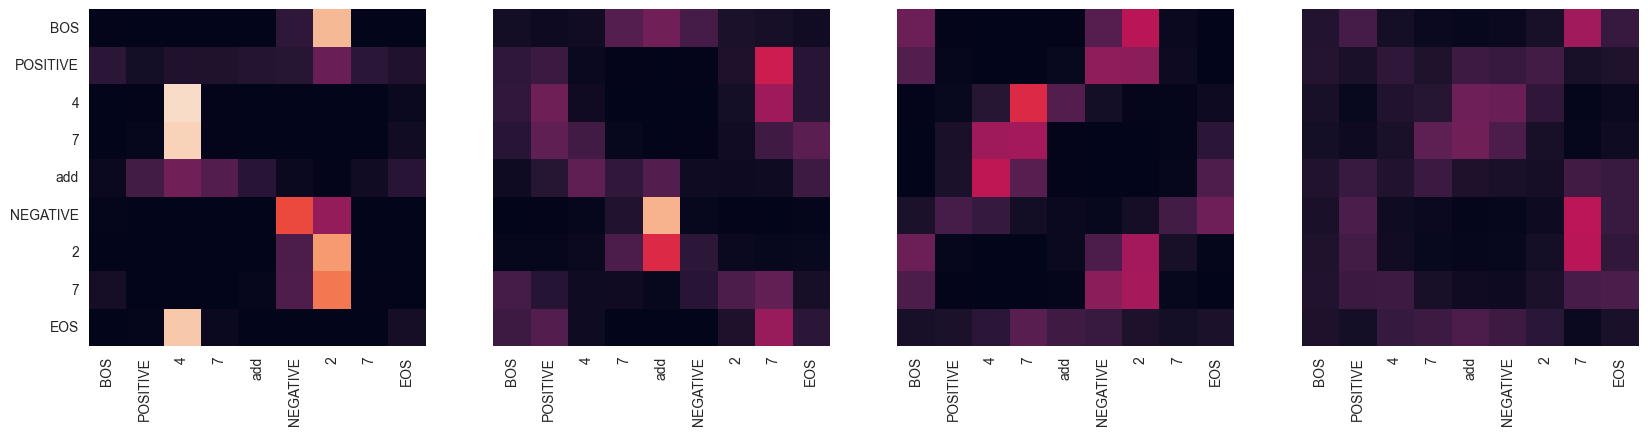

Encoder Block Number 2


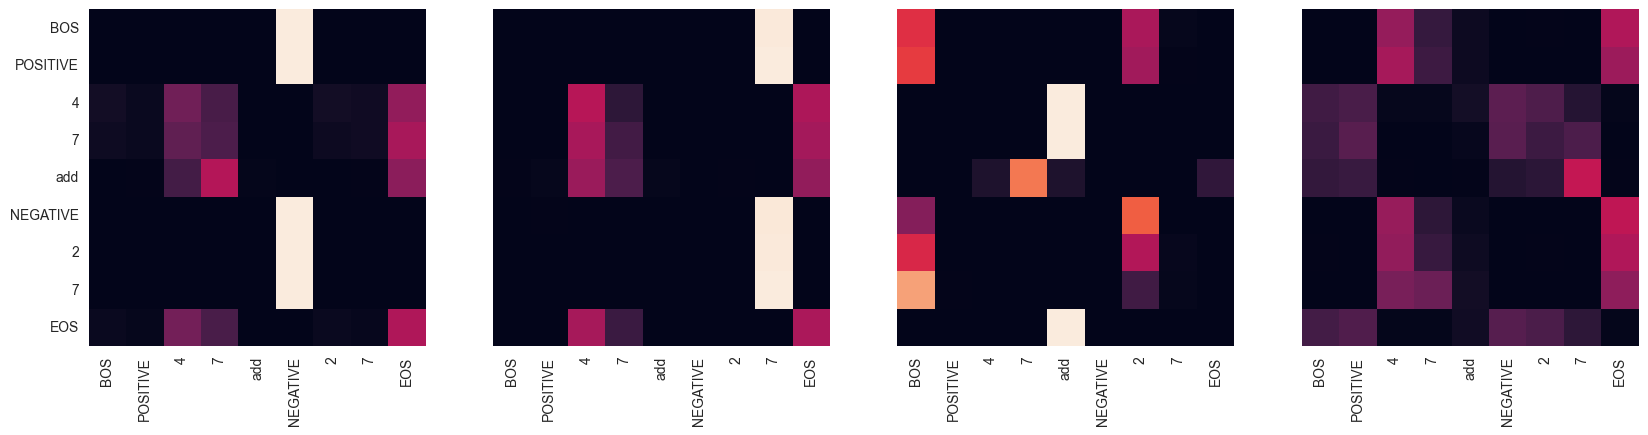

Encoder Block Number 3


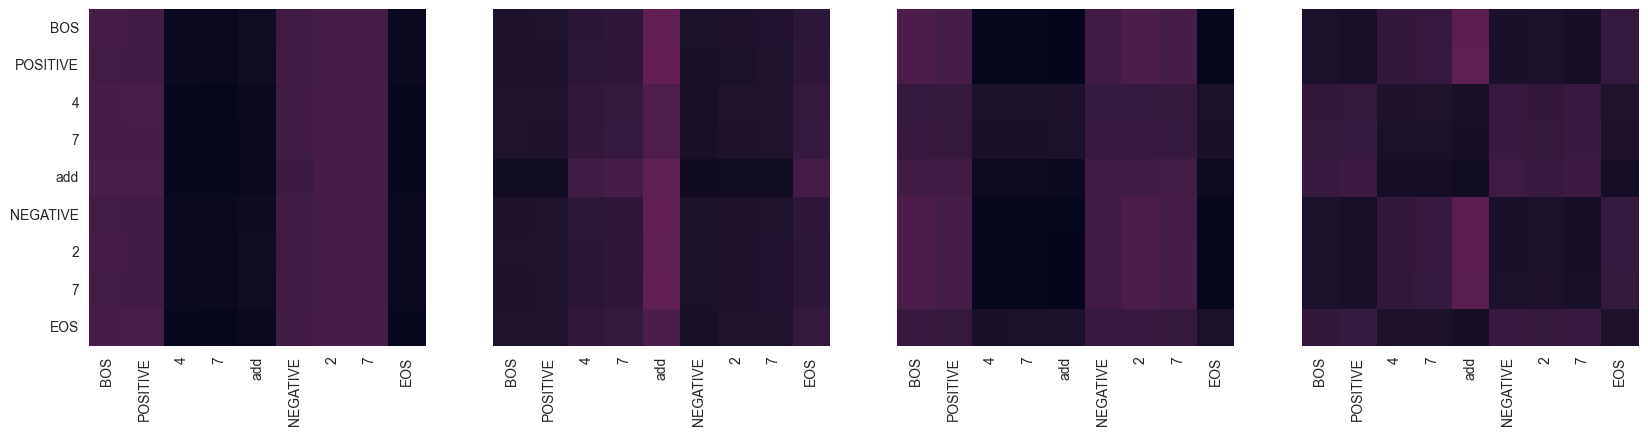

Encoder Block Number 4


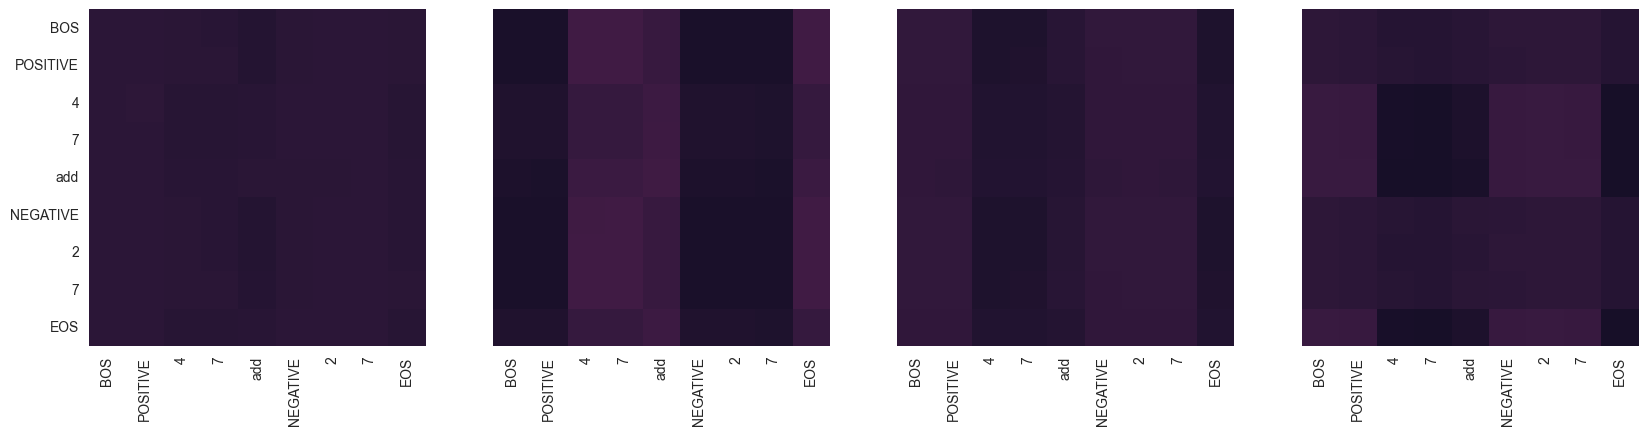

In [438]:
for layer in range(num_enc_layers):
    fig, axs = plt.subplots(1, num_heads, figsize=(20, 10))
    print("Encoder Block Number", layer + 1)
    for h in range(num_heads):
        draw(
            trained_model.encoder.layers[layer]
            .MultiHeadBlock.heads[h]
            .weights_softmax.data.cpu()
            .numpy()[0],
            inp_seq,
            inp_seq if h == 0 else [],
            ax=axs[h],
        )
    plt.show()
plt.close()

Decoder Block number  1
Decoder Self Attention 1


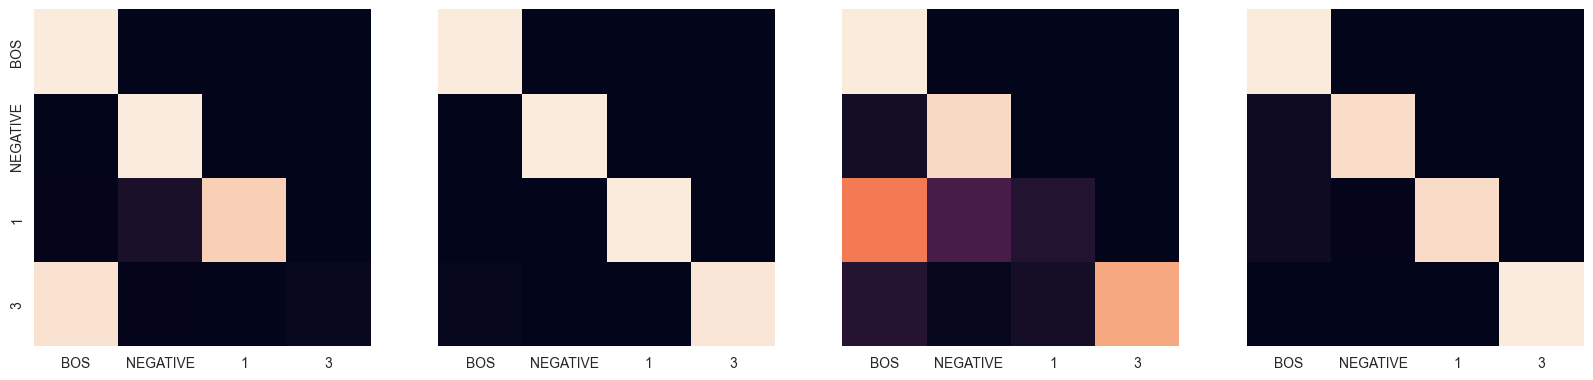

Decoder Cross attention 1


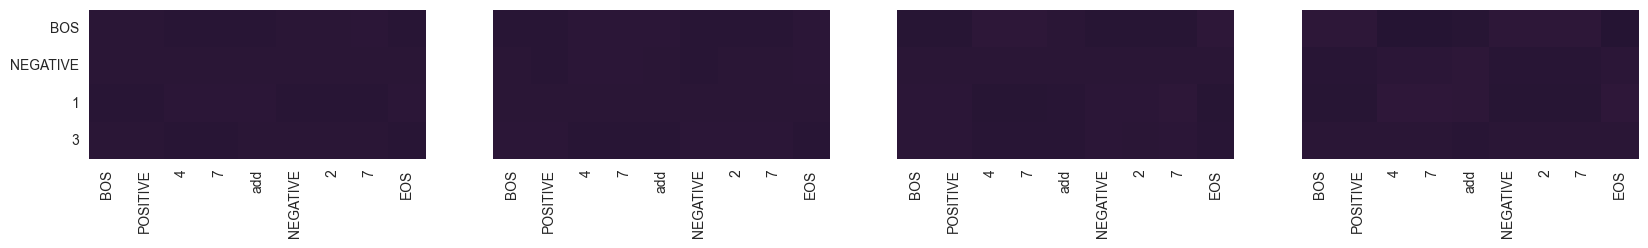

Decoder Block number  2
Decoder Self Attention 2


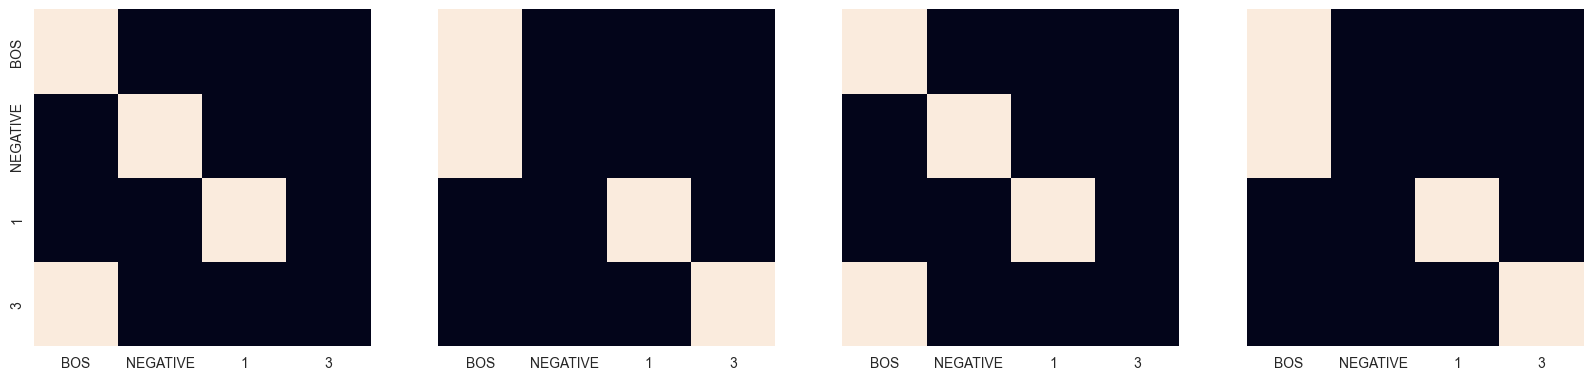

Decoder Cross attention 2


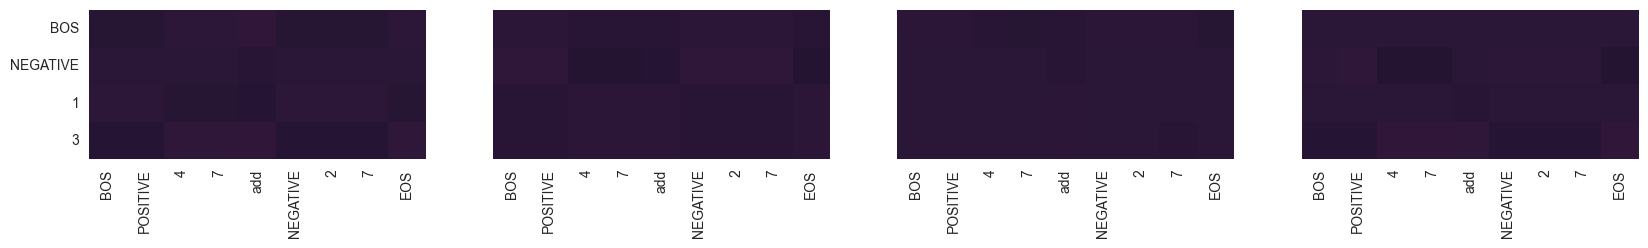

Decoder Block number  3
Decoder Self Attention 3


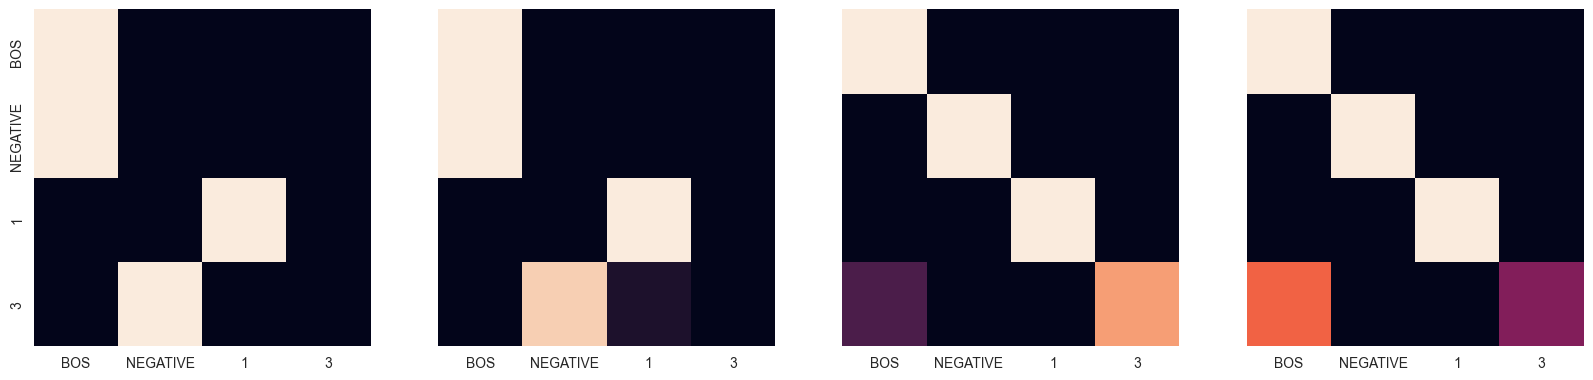

Decoder Cross attention 3


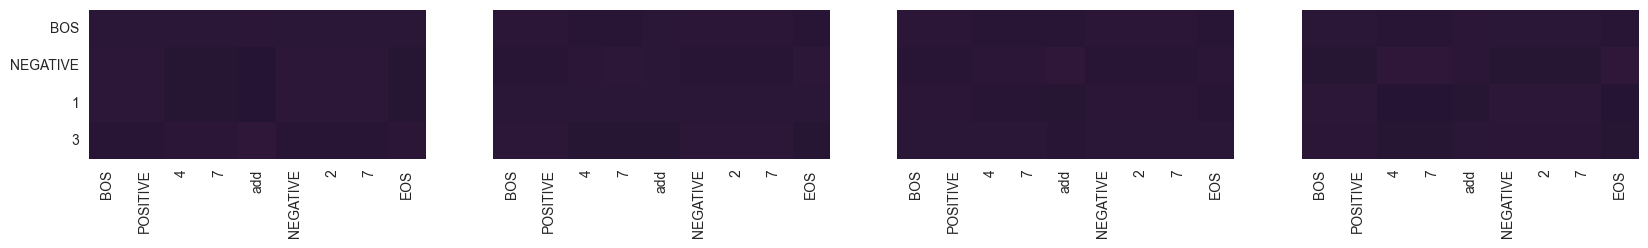

Decoder Block number  4
Decoder Self Attention 4


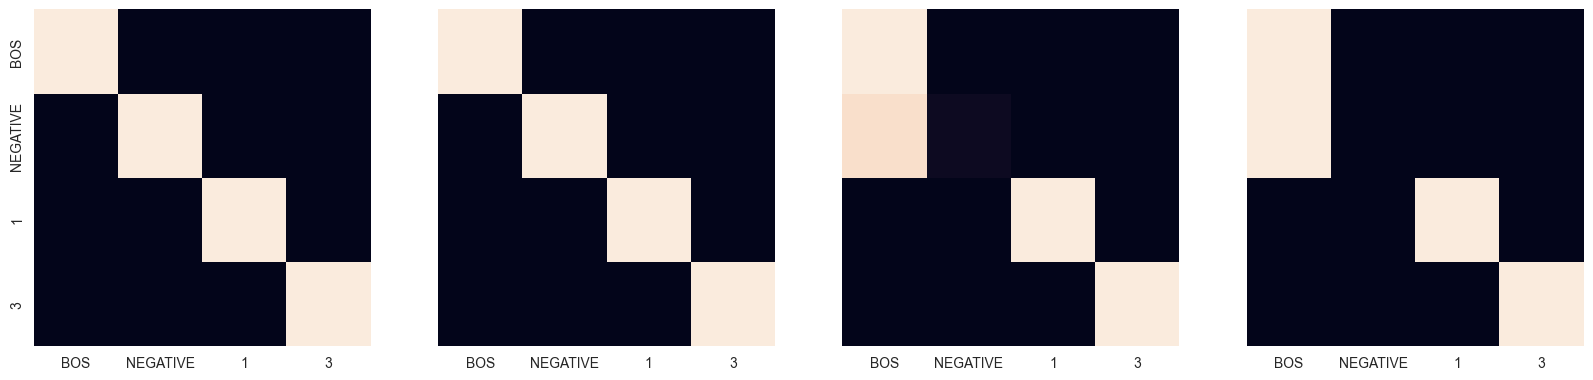

Decoder Cross attention 4


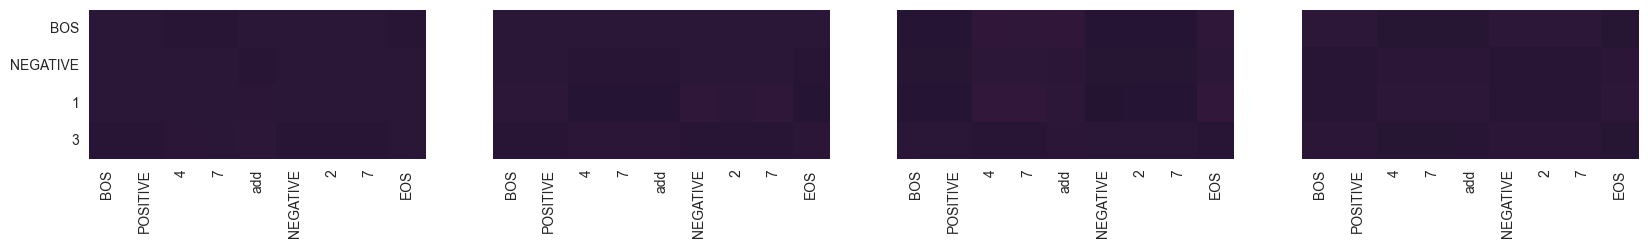

In [439]:
for layer in range(num_dec_layers):
    fig, axs = plt.subplots(1, num_heads, figsize=(20, 10))

    print("Decoder Block number ", layer + 1)

    print("Decoder Self Attention", layer + 1)
    for h in range(num_heads):
        draw(
            trained_model.decoder.layers[layer]
            .attention_self.heads[h]
            .weights_softmax.data.cpu()
            .numpy()[0],
            target_exp,
            target_exp if h == 0 else [],
            ax=axs[h],
        )
    plt.show()
    print("Decoder Cross attention", layer + 1)
    fig, axs = plt.subplots(1, 4, figsize=(20, 10))
    for h in range(num_heads):
        draw(
            trained_model.decoder.layers[layer]
            .attention_cross.heads[h]
            .weights_softmax.data.cpu()
            .numpy()[0],
            inp_seq,
            target_exp if h == 0 else [],
            ax=axs[h],
        )
    plt.show()

# Submit Your Work
After completing both notebooks for this assignment (`Transformers.ipynb` and `rnn_lstm_captioning.ipynb`), run the following cell to create a `.zip` file for you to download and turn in. 

**Please MANUALLY SAVE every `*.ipynb` and `*.py` files before executing the following cell:**

In [440]:
from dl.submit import make_assignment2_submission

make_assignment2_submission(str(ARTIFACTS_DIR))

       Assignment 2 Submission Generator

NOTE: Do NOT include these large files in your submission:
  - pretrained_model/*.pth (SimCLR weights)
  - dino_res.mp4 (DINO video)
  - data/ folder (datasets)

Creating code submission zip...
Writing to: /Users/samuelbenibgui/Desktop/Master/DL/DL-Attention/artifacts/a2_code_submission.zip
  Note: rnn_lstm_attention_submission.pt not found (will be created when you run the notebook)

Code submission created: /Users/samuelbenibgui/Desktop/Master/DL/DL-Attention/artifacts/a2_code_submission.zip
Size: 0.00 MB

Creating inline PDF submission...
(This may take a few minutes...)

⚠️  No PDFs were created.
You may need to install LaTeX: !apt-get install texlive-xetex texlive-fonts-recommended

Alternative: Use File > Print > Save as PDF in Colab for each notebook,
then merge the PDFs manually.

                  Submission Summary

Please download and submit to Lemida:
  1. a2_code_submission.zip
  2. a2_inline_submission.pdf
  3. students.txt (creat